In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

#### Flow Like Water

In [3]:
with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
the_frontier_eddies = list(frontier_sample_data.keys())
# Depths will be limited to COW depths
d_df = pd.DataFrame(columns=['T' + str(t) for t in range(30)])
for eddy in the_frontier_eddies:
    row = []
    for t in range(30):
        df = frontier_sample_data[eddy]['T' + str(t)]['COW']['x']
        row.append(df.isna().idxmax() if df.isna().any() else len(df))
    d_df.loc[eddy] = row

eddy = the_frontier_eddies[2]

sub_data = {}

for t in range(30):
    
    method = 'VG'
    sub_data['T'+str(t)] = {}
    
    df = frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_df.loc[eddy]['T'+str(t)]]
    df = df.drop('TD', axis=1)
    
    # Interpolate to Density intervals
    rho = frontier_sample_data[eddy]['T'+str(t)]['rho']
    X, Y = np.meshgrid(frontier_sample_data[eddy]['T'+str(t)]['x'],
                       frontier_sample_data[eddy]['T'+str(t)]['y'])
    points = np.column_stack((X.ravel(), Y.ravel()))
    rhoc = []
    for k, (xc, yc) in enumerate(zip(df['x'], df['y'])):
        values = rho[:, :, k].ravel()
        target_point = np.array([[xc, yc]])
        rhoc.append(griddata(points, values, target_point, method='linear')[0])
    RHO_INT = 0.05
    new_rho = np.arange(np.floor(np.nanmin(rhoc) / RHO_INT) * RHO_INT,
                        np.ceil(np.nanmax(rhoc) / RHO_INT) * RHO_INT + RHO_INT,
                        RHO_INT)
    rho_data = pd.DataFrame({
        'x': np.interp(new_rho, rhoc, df['x']),
        'y': np.interp(new_rho, rhoc, df['y']),
        'Depth': np.interp(new_rho, rhoc, df['Depth']),
        'rho': new_rho
    })
    # TD_DENSITY = 26
    # x0 = rho_data.loc[np.isclose(rho_data['rho'], TD_DENSITY)].iloc[0]['x']
    # y0 = rho_data.loc[np.isclose(rho_data['rho'], TD_DENSITY)].iloc[0]['y']
    x0 = rho_data.iloc[0]['x']
    y0 = rho_data.iloc[0]['y']
    rho_data['x'] = rho_data['x'] - x0
    rho_data['y'] = rho_data['y'] - y0
    rho_data['TD'] = np.hypot(rho_data['x'], rho_data['y'])
    
    # Interpolate to Depth intervals
    DEPTH_INT = 10
    new_depth = np.arange(0, -np.floor(df['Depth'].min()/DEPTH_INT) * DEPTH_INT + DEPTH_INT, DEPTH_INT)
    depth_data = pd.DataFrame({
        'x': np.interp(new_depth, -df['Depth'], df['x']),
        'y': np.interp(new_depth, -df['Depth'], df['y']),
        'Depth': -new_depth,
        'rho': np.interp(new_depth, -df['Depth'], rhoc),
    })
    # TD_DEPTH = -150
    # x0 = depth_data.loc[np.isclose(depth_data['Depth'], TD_DEPTH)].iloc[0]['x']
    # y0 = depth_data.loc[np.isclose(depth_data['Depth'], TD_DEPTH)].iloc[0]['y']
    x0 = depth_data.iloc[0]['x']
    y0 = depth_data.iloc[0]['y']
    depth_data['x'] = depth_data['x'] - x0
    depth_data['y'] = depth_data['y'] - y0
    depth_data['TD'] = np.hypot(depth_data['x'], depth_data['y'])

    sub_data['T'+str(t)]['rho_data'] = rho_data
    sub_data['T'+str(t)]['depth_data'] = depth_data
    print(t)





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


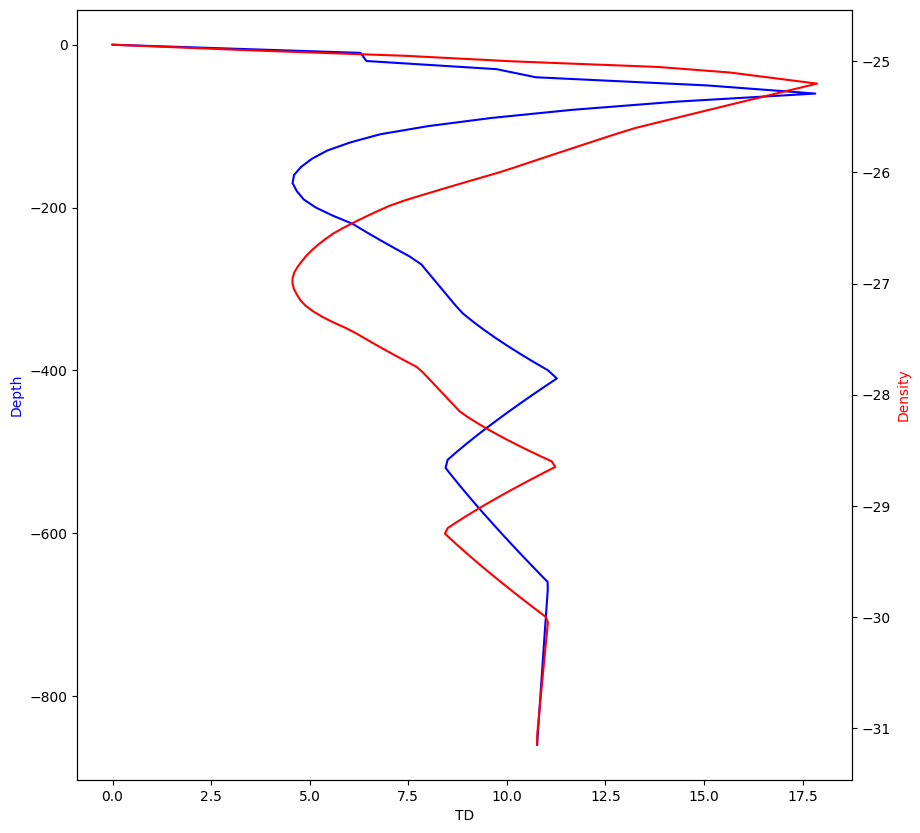

In [4]:
fig, ax1 = plt.subplots(figsize=(10, 10))
# Plot depth data
ax1.plot(depth_data['TD']/1000, depth_data['Depth'], 'b-')
ax1.set_xlabel('TD')
ax1.set_ylabel('Depth', color='b')

# Create a second y-axis for density data
ax2 = ax1.twinx()
ax2.plot(rho_data['TD']/1000, -rho_data['rho'], 'r-')
ax2.set_ylabel('Density', color='r')

plt.show()

### Best Shift with rho

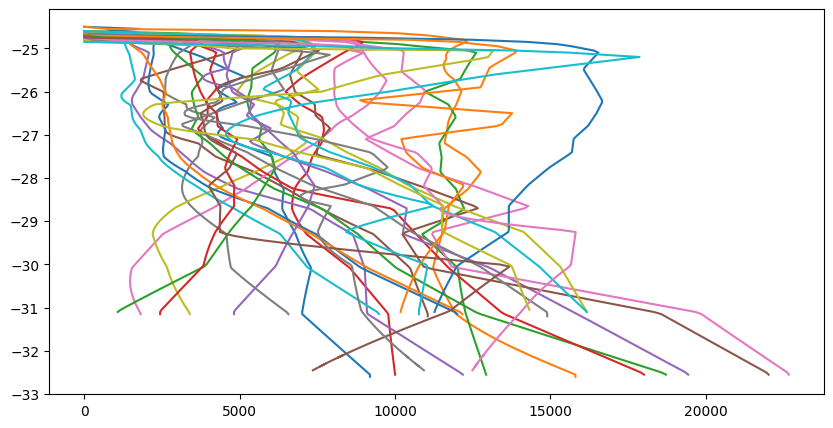

In [20]:
plt.figure(figsize=(10, 5))

medium = 'TD'
dfs_x = []
dfs_y = []
dfs_TD = []
for t in range(30):
    rho_data = sub_data['T'+str(t)]['rho_data'][['rho', 'x']]
    rho_data.columns = ['rho', 'x'+str(t)]
    dfs_x.append(rho_data.set_index('rho'))  

    rho_data = sub_data['T'+str(t)]['rho_data'][['rho', 'y']]
    rho_data.columns = ['rho', 'y'+str(t)]
    dfs_y.append(rho_data.set_index('rho'))  

    rho_data = sub_data['T'+str(t)]['rho_data'][['rho', 'TD']]
    rho_data.columns = ['rho', 'TD'+str(t)]
    dfs_TD.append(rho_data.set_index('rho'))  

rho_df_x = pd.concat(dfs_x, axis=1) 
rho_df_y = pd.concat(dfs_y, axis=1) 
rho_df_TD = pd.concat(dfs_TD, axis=1) 

for col in rho_df_TD.columns:
    plt.plot(rho_df_TD[col], -rho_df_TD.index)


In [30]:
rho_df_x

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29
rho,,,,,,,,,,,,,,,,,,,,,
24.50,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.55,1345.457789,-708.568787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.60,262.689697,-7658.600149,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.65,-336.835870,-9809.392615,-2835.683707,0.000000,137.995164,-1003.476766,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.70,-1105.004389,-10975.461670,-4015.073103,1526.910322,1903.694531,-1912.889271,-1170.356932,63.355939,-504.392873,91.506048,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2764.814346,8710.165477,10216.191200,NaN,NaN
32.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3027.875388,8821.459760,10433.949113,NaN,NaN
32.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3115.562402,8858.557854,10506.535084,NaN,NaN


In [108]:
def rotate_y_xy(points, theta_deg):
    """Rotate points (x, y) about the y-axis by angle theta (in degrees)."""
    theta = np.deg2rad(theta_deg)  # Convert degrees to radians
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    xy_rotated = np.dot(points[:, :2], rotation_matrix.T)
    return np.hstack((xy_rotated, points[:, 2:]))

x0, y0 = rho_df_x['x14']/1000, rho_df_y['y14']/1000
points0 = np.column_stack((x0, y0))

shift_df = pd.DataFrame(columns=['Day', 'theta', 'i', 'j', 'rmse'])

tic = time.time()
for t in range(10, 20):

    x, y = rho_df_x['x'+str(t)]/1000, rho_df_y['y'+str(t)]/1000
    points = np.column_stack((x, y))

    for theta_shift in np.arange(0, 360, 30):
        
        points_rotated = rotate_y_xy(points, theta_shift)

        for i_shift in range(-15, 15):
            for j_shift in range(-15, 15):

                points_shifted = np.column_stack((points_rotated[:,0] + i_shift,
                                                  points_rotated[:,1] + j_shift))

                rmse = np.sqrt(np.nanmean((points_shifted - points0) ** 2))
                
                shift_df.loc[len(shift_df)] = {
                    'Day': t,
                    'theta': theta_shift,
                    'i': i_shift,
                    'j': j_shift,
                    'rmse': rmse
                }
    print(t)
toc = time.time()
print(f"Elapsed time: {toc - tic:.4f} seconds")

# 40 min for 5 days

10
11
12
13
14
15
16
17
18
19
Elapsed time: 112.4031 seconds


In [109]:
# day_df = shift_df.loc[shift_df['Day'] == t]
# day_df.loc[day_df['rmse'] == day_df['rmse'].min()]
best_shift_df = pd.DataFrame()
for t in shift_df['Day'].unique():
    day_df = shift_df.loc[shift_df['Day'] == t]
    best_shift_df = pd.concat([best_shift_df, day_df.loc[[day_df['rmse'].idxmin()]]])
best_shift_df


,Day,theta,i,j,rmse
500,10,0,1,5,0.982777
11300,11,0,1,5,0.795938
22067,12,0,0,2,0.672166
32867,13,0,0,2,0.750929
43665,14,0,0,0,0.000000
54493,15,0,1,-2,0.984856
65351,16,0,3,-4,1.461010
76154,17,0,3,-1,1.134554
86952,18,0,3,-3,0.837677
97782,19,0,4,-3,0.820982


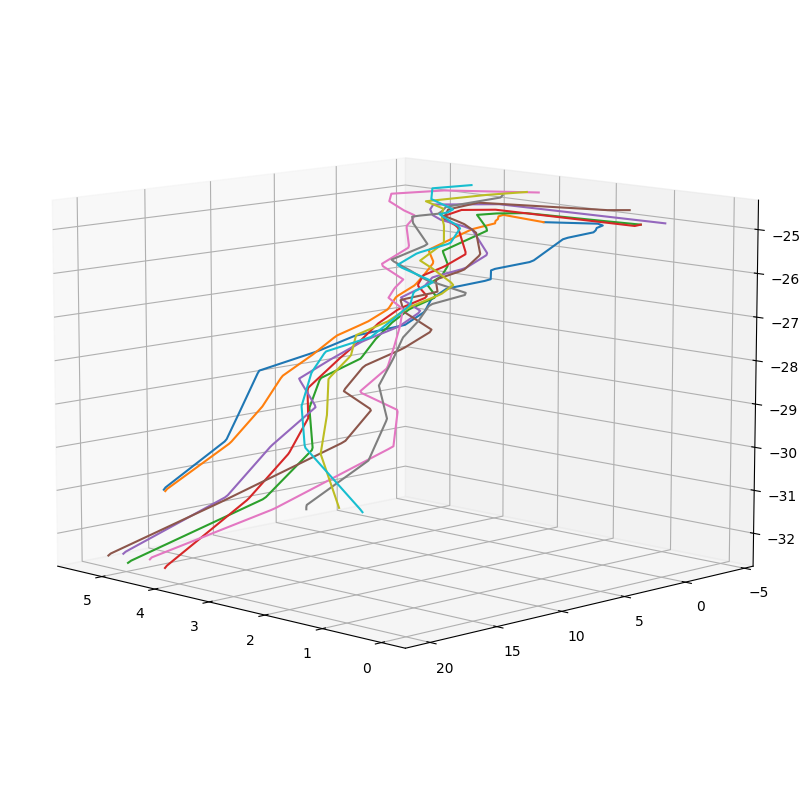

In [112]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for _, row in best_shift_df.iterrows():
    t, theta, i, j = int(row['Day']), row['theta'], row['i'], row['j']

    x, y = rho_df_x[f'x{t}']/1000, rho_df_y[f'y{t}']/1000
    x, y = rotate_y_xy(np.column_stack((x, y)), theta).T
    x, y = x + i, y + j

    ax.plot(x, y, -rho_df_x.index)
ax.view_init(elev=10, azim=135)


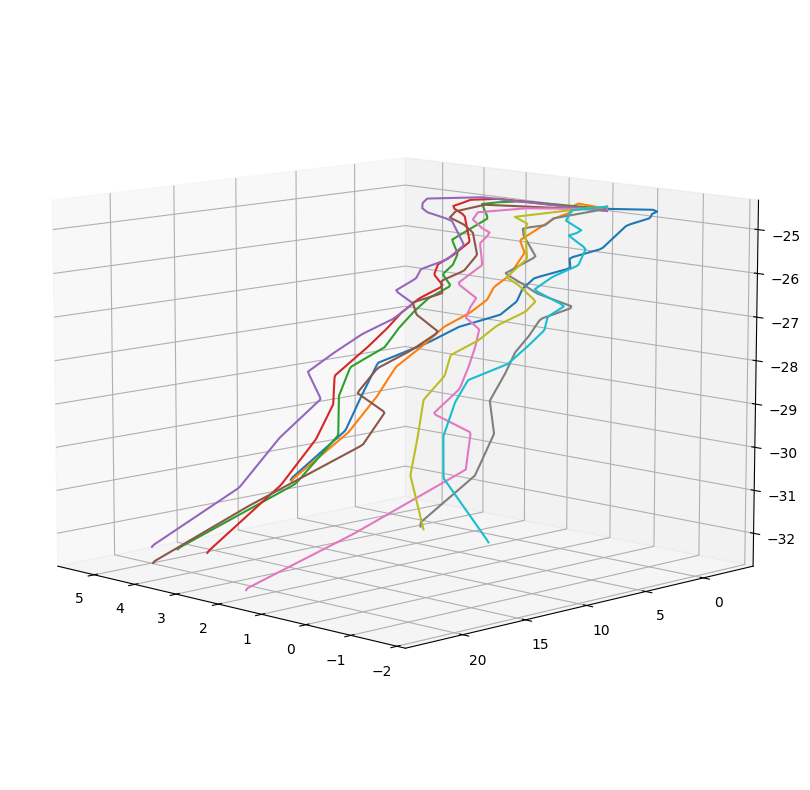

In [113]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for _, row in best_shift_df.iterrows():
    t, theta, i, j = int(row['Day']), row['theta'], row['i'], row['j']

    x, y = rho_df_x[f'x{t}']/1000, rho_df_y[f'y{t}']/1000

    ax.plot(x, y, -rho_df_x.index)
ax.view_init(elev=10, azim=135)

### Best shift with Depth


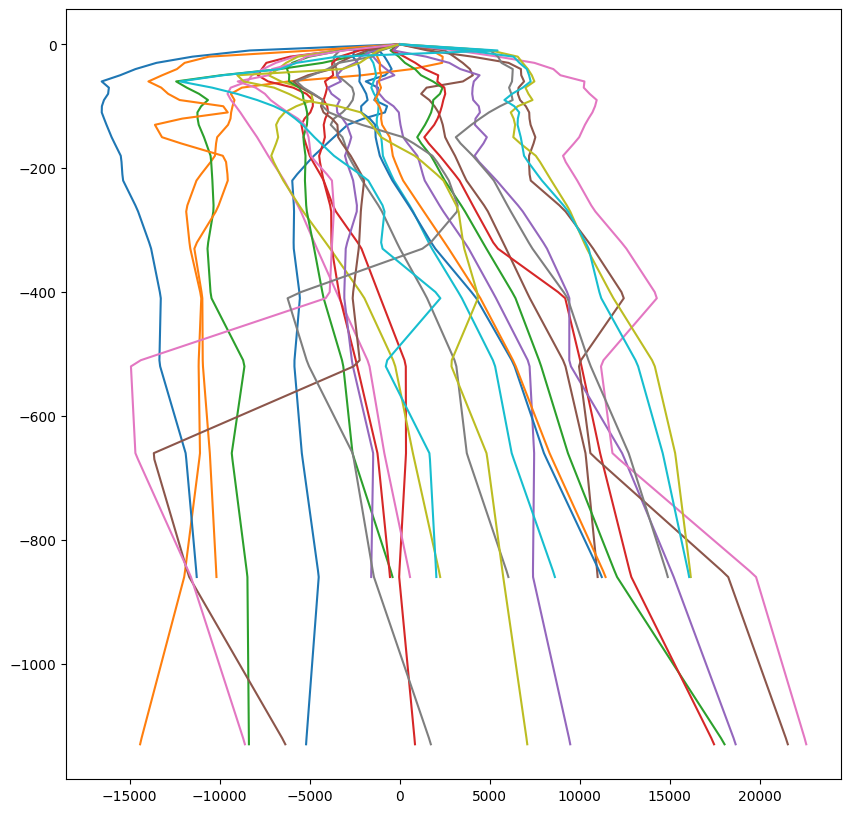

In [10]:
plt.figure(figsize=(10, 10))

medium = 'y'

dfs = []
for t in range(30):
    depth_data = sub_data['T'+str(t)]['depth_data'][['Depth', medium]]

    depth_data.columns = ['Depth', medium+str(t)]
    dfs.append(depth_data.set_index('Depth'))  # Set 'Depth' as index for clarity and to avoid confusion

combined_df = pd.concat(dfs, axis=1)  # Concatenate along columns

for col in combined_df.columns:
    plt.plot(combined_df[col], combined_df.index)


In [11]:
combined_df

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y20,y21,y22,y23,y24,y25,y26,y27,y28,y29
Depth,,,,,,,,,,,,,,,,,,,,,
-0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-10.0,-1147.106706,1793.918321,-1201.174978,-3415.952647,-1385.409226,2511.894345,-3563.837732,-3323.274453,-3438.767533,-1838.455435,...,-8329.149971,-4857.126128,-3217.356222,-2226.803656,-1453.109639,-1796.921504,-3096.807120,-1031.828286,-1179.814150,5437.303260
-20.0,-838.864420,2389.914146,-2714.203714,-6086.939950,-1468.870871,3025.231848,-5848.666296,-3661.923448,-5654.184263,-1677.238678,...,-11511.228659,-10594.785119,-5027.943342,-3340.739561,-2178.257663,-2681.608455,-5195.659720,-1525.166512,-1701.359422,-3475.730639
-30.0,-627.882392,2361.786375,-4282.789988,-7405.430002,-1168.014234,3504.083436,-6879.256439,-3639.384644,-6307.957906,-1462.742471,...,-13508.784383,-11942.868486,-5967.613910,-3749.311304,-2469.531468,-3388.258471,-5762.147874,-3377.535367,-2217.138627,-5732.309272
-40.0,-445.046447,692.113857,-6657.658718,-7656.211196,-755.324273,3900.703785,-7581.555014,-3500.387637,-6751.633171,-1370.360563,...,-14670.109679,-12368.943350,-6253.246555,-3737.966350,-3176.469401,-3769.731679,-7083.671042,-4009.879570,-3162.580525,-6626.604329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1090.0,-5094.988152,-14061.621869,-8383.962003,724.747584,9176.669795,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-7123.079612,-9029.060877,1275.305738,6895.621576,NaN
-1100.0,-5121.084827,-14152.669307,-8380.859104,757.378996,9253.462179,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-6924.623617,-8917.674442,1392.823984,6945.267651,NaN
-1110.0,-5147.181502,-14243.716745,-8377.756206,790.010408,9330.254564,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-6726.167623,-8806.288008,1510.342230,6994.913726,NaN
